# 这里是一份测试我的各部分程序是否正常的代码(This is a code for examining my each part of net weather correct or not)

In [1]:
import torch
from forward import Wave_Forward
import numpy as np
import matplotlib.pyplot as plt
from dataset import FWI_Dataset
import torch.utils.data.dataloader as DataLoader
import deepwave
from deepwave import scalar
import random
import os

In [2]:
def fro(a:torch.Tensor):
    return torch.sqrt(torch.sum(a**2))

examine the 268th pic...


/home/lr/anaconda3/envs/pytorch/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/lr/anaconda3/envs/pytorch/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


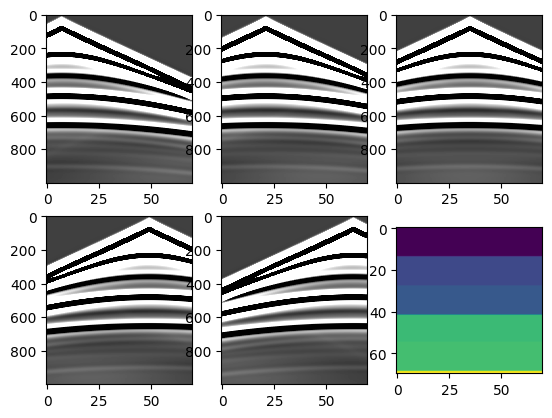

In [3]:
root_file="/data1/lr/FWIDATA/train/"
order = random.randint(0,len(os.listdir(root_file)))

print(f"examine the {order}th pic...")
data = torch.load(f"/data1/lr/FWIDATA/train/data_{order}")
seis_data = data['seis_data']
v = data['velocity'][0]

fig, axs = plt.subplots(2, 3)
for i,ax in enumerate(axs.flatten()[:-1]):
    ax.imshow(seis_data[i],aspect='auto',cmap='gray',vmin=-0.02,vmax=0.06)
axs.flatten()[-1].imshow(v)

## test my simulation program

torch.Size([1000, 70])


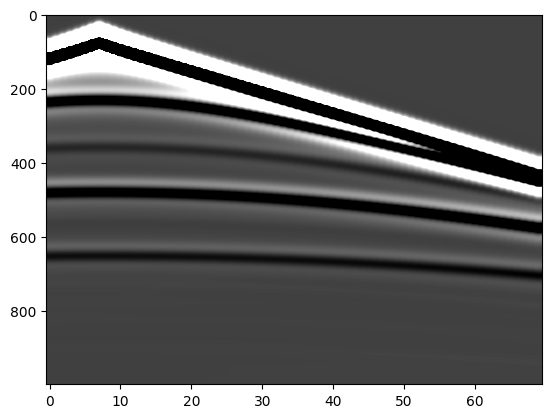

In [4]:
# v = v[0]
v = torch.tensor(v)
dt = 0.001
dx = dz = 10
nt = 1000
s_loc = (70,0)
pml = 120
freq = 15
model = Wave_Forward(velocity_model=v,
                    x_grid_nums=70,
                    z_grid_nums=70,
                    dx=dx,
                    bgnums=pml,
                    nt=nt,
                    dt=dt,
                    freq=freq,
                    s_loc=s_loc,
                    r_loc=[(i,0)for i in range(0,700,10)])
p = model.forward()
print(p.shape)
plt.imshow(p, aspect='auto',vmin=-0.2,vmax=0.6,cmap='gray')
plt.show()

In [5]:
fro(p-seis_data[0])

tensor(0.4542)

## test the deepwave program

In [41]:
## config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ny = 70
nx = 70
dx = 10

# source
ns, nr = 5, 70
source_locations = torch.zeros(ns, 1, 2, dtype=torch.long, device=device)
receiver_locations = torch.zeros(ns, nr, 2, dtype=torch.long, device=device)

source_locations[...,1] = torch.tensor([[7],[21],[35],[49],[63]])
source_locations[:, 0, 0] = 0

receiver_locations[..., 1] = ((torch.arange(nr)).repeat(ns, 1))
receiver_locations[:, :, 0] = 0

freq = 15  # 波频
nt = 1000  # 时间步
dt = 0.001  # 时间间隔(s)
peak_time = 73/1000  # 峰值时间,指地震波传播过程中最大振幅出现的时间


source_amplitudes = (
    deepwave.wavelets.ricker(freq, nt, dt, peak_time)
    .repeat(ns, 1, 1).to(device)
)  # 构造ricker对象


In [42]:
out = scalar(v.to(device), dx, dt, source_amplitudes=source_amplitudes,
             source_locations=source_locations,
             receiver_locations=receiver_locations,
             accuracy=4,
             pml_width=120,
             pml_freq=freq)

In [46]:
out[-1].shape

torch.Size([5, 70, 1000])

In [49]:
p2 = out[-1].permute(0,2,1).to('cpu')

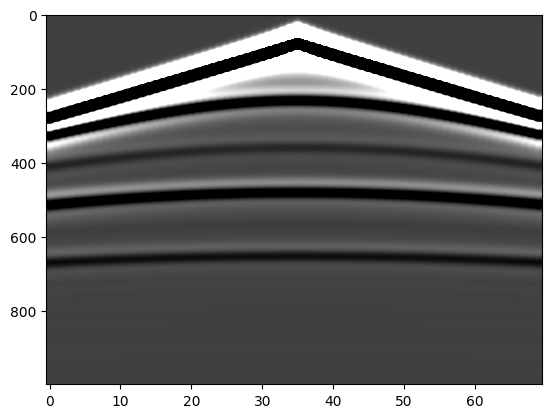

In [52]:
plt.imshow(p2[2], aspect='auto',vmin=-0.2,vmax=0.6,cmap='gray')

In [53]:
p[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0005, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [54]:
p2[0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0005, 0.0005, 0.0005,  ..., 0.0002, 0.0002, 0.0002],
        [0.0005, 0.0005, 0.0005,  ..., 0.0002, 0.0002, 0.0002],
        [0.0005, 0.0005, 0.0005,  ..., 0.0003, 0.0002, 0.0002]])

### deppwave的输出seis_data第0时刻的值应该舍掉,做比较的时候deepwave的输出取从第一个时间步开始,其他的舍去最后一个时间步

In [57]:
fro(p[:-1]-p2[0][1:])

tensor(0.5150)

In [56]:
fro(seis_data[:,:-1,:]-p2[:,1:,:])

tensor(2.0146)

精度的问题???正演程序与OPENFWI的数据略有出入,随时间增大